# Menu <a class="anchor" id="menu"></a>

* [1. Segmentation par **RFM** ](#rfm)
    * [1.1 Calcul de la `Recence`](#rfm_R)
    * [1.2 Calcul de la `Frequence`](#rfm_F)
    * [1.3 Calcul du `Montant`](#rfm_M)
    * [1.4 Calcul des `scores RFM`](#rfm_scores)
    * [1.5 Interprétation des groupes](#rfm_interpretation)
    * [1.6 Conclusion](#rfm_conclusion)
* [2. Feature Engineering pour modèles non-supervisés](#fe)
* [3. Segmentation par **KMeans** ](#kmeans)
    * [3.1 Modèle de référence](#kmeans_ref)
    * [3.2 Modèle avec Feature Engineering](#kmeans_fe)
    * [3.3 Modèle avec Elbow method](#kmeans_elbow)
    * [3.4 Modèle avec GridSearchCV](#kmeans_grid)
* [4. Segmentation par **CAH** ](#cah)
    * [4.1 Modèle de référence](#cah_ref)
    * [4.2 Modèle avec Feature Engineering](#cah_fe)
    * [4.3 Modèle avec Elbow method](#cah_elbow)
    * [4.4 Modèle avec GridSearchCV](#cah_grid)
* [4. Segmentation par **DBScan** ](#dbscan)
    * [5.1 Modèle de référence](#dbscan_ref)
    * [5.2 Modèle avec Feature Engineering](#dbscan_fe)
    * [5.3 Modèle avec Elbow method](#dbscan_elbow)
    * [5.4 Modèle avec GridSearchCV](#dbscan_grid)
* [5. Comparaison des modèles ](#unsupervised_comparison)

# La segmentation

Segmenter consiste à **créer des segments homogènes de clients** que l’on peut ensuite activer dans des campagnes marketing ciblées. Cette approche permet de mieux cibler les campagnes et scénarios marketing; on segmente les clients en fonction de critères de segmentation.

Il y a théoriquement autant de méthodes de segmentation qu’il y a de critères et de combinaisons de critères possibles. Mais certaines méthodes se sont imposées en raison de leur efficacité.

---
# Préparatifs 

In [1]:
import os
# import re
import time
# import math
# import string
import datetime
# import unicodedata
# import json
from zipfile import ZipFile
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)

# import gc
# gc.enable()

In [2]:
def load_from_zip(csv_name):
    return pd.read_csv(ZipFile(os.path.join("data", f"{csv_name}.zip")).open(csv_name))


# data_geo = load_from_zip("olist_geolocation_dataset.csv")
# data_geo = pd.read_csv(os.path.join('data',"olist_geolocation_dataset_clean.csv"))

# data_customer = load_from_zip("olist_customers_dataset_clean.csv")
data_customer = pd.read_csv(os.path.join('data', "olist_customers_dataset_clean.csv"))

# data_orders = load_from_zip("olist_orders_dataset.csv")
data_orders = pd.read_csv(os.path.join('data', "olist_orders_dataset_clean.csv"))

# data_items = load_from_zip("olist_order_items_dataset.csv")
data_items = pd.read_csv(os.path.join('data', "olist_order_items_dataset_clean.csv"))

# data_products = load_from_zip("olist_products_dataset.csv")
# data_products = pd.read_csv(os.path.join('data',"olist_products_dataset_clean.csv"))

# data_payments = load_from_zip("olist_order_payments_dataset.csv")
data_payments = pd.read_csv(os.path.join('data', "olist_order_payments_dataset_clean.csv"))

# data_reviews = load_from_zip("olist_order_reviews_dataset.csv")
data_reviews = pd.read_csv(os.path.join('data', "olist_order_reviews_dataset_clean.csv"))

# data_sellers = pd.read_csv(os.path.join('data',"olist_sellers_dataset_clean.csv"))
# data_categories = pd.read_csv(os.path.join('data',"product_category_name_translation_clean.csv"))

---
# 1. Segmentation RFM *(Récence, Fréquence et Montant)* <a class="anchor" id="rfm"></a> [⇪](#menu)

La segmentation RFM est l’une des techniques de segmentation incontournables pour améliorer le ciblage marketing et augmenter le revenu par client. 

Cette méthode est une **segmentation 100% comportementale**; on ne segmente pas  les clients en fonction de ce qu’ils sont *(genre, sexe, ville, CSP...)*, ni en fonction de ce qu’ils aiment *(centres d’intérêt, goûts)*, mais en fonction de ce qu’ils achètent.

Le principe sous-jacent est simple : un client qui a acheté récemment, qui achète fréquemment et qui génère beaucoup de chiffre d’affaires commandera à nouveau, à coup quasiment sûr.

La segmentation RFM repose sur ces 3 critères :
- La **Récence** : Combien de temps s’est-il écoulé depuis la dernière activité du client *(achat/visite web/visite app...)* ?
- La **Fréquence** : Au cours d’une période de temps donnée, combien de fois un client a-t-il acheté ou interagi avec la marque ? 
- Le **Montant** : Combien un client a-t-il dépensé d’argent au cours d’une période de temps donnée ?

## Préparatifs

> **Temporalité** : comme nos analyses ont montrés que l'activité n'était pas fiable au début et à la fin de la timeline disponible, nous pourrions restreintre notre jeu de données entre **Janvier 2017** et **Aout 2018**. Mais comme il est recommandé de faire une RFM sur une période cyclique et réutilisable d'une semaine, d'un mois ou d'une année, nous allons prendre les données allant de fin août 2017 à fin août 2018 (donc les données les plus récentes sur 1 an).

#### D'abord on restreint la selection entre le 01/09/2017 et le 01/09/2018 pour avoir une période d'un an et on ne garde que ceux dont le processus de livraison est allé jusqu'au bout (delivered)

In [3]:
selection1 = data_orders[
    (data_orders.order_purchase_timestamp >= '2017-09-01 00:00:00') & 
    (data_orders.order_purchase_timestamp < '2018-09-01 00:00:00') & 
    (data_orders.order_status == 'delivered')][['order_id', 'customer_id', 'order_purchase_timestamp']]
selection1.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


#### Puis on associe ces commandes aux id uniques des clients qui les ont passées

In [4]:
selection2 = selection1.merge(data_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
selection2.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


## 1.1 Calcul de la `Récence` <a class="anchor" id="rfm_R"></a> [⇪](#menu)

#### On converti la date d'achat en nombre de jours écoulés *(depuis le moment ou l'on arrête notre selection donc le 01/09/2018)*

In [5]:
ref_date = datetime.datetime.strptime('2018-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
selection3 = selection2.copy()

selection3.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
selection3['days_ago'] = selection3.order_purchase_timestamp - ref_date
selection3['days_ago'] = selection3.days_ago.apply(lambda x: x.days)
selection3.drop(columns=['order_purchase_timestamp'], inplace=True)
selection3.head()

,order_id,customer_id,customer_unique_id,days_ago
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,-334
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,-39
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,-24
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,-287
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,-200


In [6]:
selection3.describe().T

,count,mean,std,min,25%,50%,75%,max
days_ago,74213.0,-176.203778,99.367873,-365.0,-263.0,-176.0,-92.0,-3.0


#### Puis, on crée une **nouvelle table** `R_data` qui stoque la **recence** *(la plus petite valeur `days_ago`)* de chaque client

In [7]:
R_data = selection3[['customer_unique_id', 'days_ago']].groupby('customer_unique_id').min().reset_index()
R_data.rename(columns={'days_ago': 'recence'}, inplace=True)
R_data.head()

,customer_unique_id,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,-114
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-117
2,0000f6ccb0745a6a4b88665a16c9f078,-324
3,0004aac84e0df4da2b147fca70cf8255,-291
4,0004bd2a26a76fe21f786e4fbd80607f,-149


In [8]:
R_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.54805,99.464265,-365.0,-264.0,-176.0,-92.5,-3.0


## 1.2 Calcul de la `Fréquence` <a class="anchor" id="rfm_F"></a> [⇪](#menu)

#### On ajoute la fréquence de chaque commande; c'est à dire 1...

In [9]:
selection4 = selection3.copy()
selection4['frequence'] = 1

#### Puis, on crée une **nouvelle table** `F_data` qui stoque la **frequence** *(le total du nombre de commande passées dans la période choisie)* de chaque client

In [10]:
F_data = selection4[['customer_unique_id', 'frequence']].groupby('customer_unique_id').sum().reset_index()
F_data.sort_values('frequence', ascending=False).head()

,customer_unique_id,frequence
39752,8d50f5eadf50201ccdcedfb9e2ac8455,11
17595,3e43e6105506432c953e165fb2acf44c,9
28323,6469f99c1f9dfae7733b25662e7f1782,7
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,7
57218,ca77025e7201e3b30c44b472ff346268,7


In [11]:
F_data.describe().T

,count,mean,std,min,25%,50%,75%,max
frequence,72247.0,1.027212,0.185742,1.0,1.0,1.0,1.0,11.0


## 1.3 Calcul du `Montant` <a class="anchor" id="rfm_M"></a> [⇪](#menu)

#### On calcul le montant total de chaque commande *(puisqu'il peut y avoir plusieurs moyens de paiements)*

In [12]:
total_amount_per_order = selection3[['order_id']].merge(
        data_payments[['order_id', 'payment_value']], on='order_id', how='left'
    ).groupby('order_id').sum().reset_index()
total_amount_per_order.rename(columns={'payment_value': 'montant'}, inplace=True)
total_amount_per_order.head()

,order_id,montant
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,000229ec398224ef6ca0657da4fc703e,216.87
2,00024acbcdf0a6daa1e931b038114c75,25.78
3,00054e8431b9d7675808bcb819fb4a32,31.75
4,000576fe39319847cbb9d288c5617fa6,880.75


#### Puis, on crée une **nouvelle table** `M_data` qui stoque le **montant** *(le total des montants de toutes les commandes faites sur la période choisie)* pour chaque client

In [13]:
M_data = selection3[['customer_unique_id', 'order_id']].merge(
        total_amount_per_order, on='order_id', how='left'
    ).groupby('customer_unique_id').sum().reset_index()
M_data.head()

,customer_unique_id,montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


In [14]:
M_data.describe().T

,count,mean,std,min,25%,50%,75%,max
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


## 1.4 Calcul des `scores RFM` <a class="anchor" id="rfm_scores"></a> [⇪](#menu)

#### On associe les trois jeux de données `R_data`, `F_data` et `M_data` en un unique jeu de données `RFM_data`

In [15]:
RFM_data = reduce(lambda x, y: pd.merge(x, y, on='customer_unique_id', how='left'), [R_data, F_data, M_data])
RFM_data.sort_values(['frequence', 'recence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant
39752,8d50f5eadf50201ccdcedfb9e2ac8455,-361,11,557.15
17595,3e43e6105506432c953e165fb2acf44c,-348,9,1172.66
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,-292,7,959.01
57218,ca77025e7201e3b30c44b472ff346268,-327,7,1122.72
28323,6469f99c1f9dfae7733b25662e7f1782,-347,7,758.83
...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10


In [16]:
RFM_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.548050,99.464265,-365.0,-264.00,-176.0,-92.50,-3.00
frequence,72247.0,1.027212,0.185742,1.0,1.00,1.0,1.00,11.00
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


#### Puis, on utilise les quantiles pour calculer les seuil de répartition des scores pour chacune des 3 colonnes...

In [17]:
num_groups = 3  # En combien de groupes voulont nous découper nos scores

R_groups = RFM_data.recence.quantile(np.linspace(0, 1, num_groups+1))
R_groups.pop(0)

F_groups = RFM_data.frequence.quantile(np.linspace(0, 1, num_groups+1))
F_groups.pop(0)

M_groups = RFM_data.montant.quantile(np.linspace(0, 1, num_groups+1))
M_groups.pop(0)

0.0

In [18]:
r_start, f_start, m_start = 0,0,0
for i, (r, f, m) in enumerate(zip(R_groups, F_groups, M_groups)):
    print(f"score:{i} | Recence:[{r_start:6};{r:6}] | Frequence:[{f_start:6};{f:6}] | Montant:[{m_start:6};{m:6}]")
    r_start, f_start, m_start = r, f, m

score:0 | Recence:[     0;-229.0] | Frequence:[     0;   1.0] | Montant:[     0; 75.25]
score:1 | Recence:[-229.0;-122.0] | Frequence:[   1.0;   1.0] | Montant:[ 75.25;152.71]
score:2 | Recence:[-122.0;  -3.0] | Frequence:[   1.0;  11.0] | Montant:[152.71;7274.88]


>#### 🔔 On note que les **scores de fréquence vont présenter un problème** puisque le score 2 est inexistant de par la répartition des achats
> *(rappelons que notre Analyse Exploratoire des données a montrée que seuls environ 3% des clients font plus d'un achat)*

#### On utilise les seuils pour calculer et ajouter les scores `R_score`, `F_score` et `M_score` des 3 colonnes `recence`, `frequence` et `montant`

In [19]:
def eval_score(x, split_values):
    for i, v in enumerate(split_values):
        if(x <= v):
            return i+1

    print(f"probleme: value={x}\n", split_values)
    raise Exception


RFM_data['R_score'] = RFM_data.recence.apply(eval_score, split_values=R_groups)
RFM_data['F_score'] = RFM_data.frequence.apply(eval_score, split_values=F_groups)
RFM_data['M_score'] = RFM_data.montant.apply(eval_score, split_values=M_groups)
RFM_data['RFM_score'] = RFM_data[['R_score', 'F_score', 'M_score']].apply(
    lambda row: int(''.join(row.values.astype(str))), axis=1
)

In [20]:
RFM_data.sort_values(['recence', 'frequence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant,R_score,F_score,M_score,RFM_score
26076,5c58de6fb80e93396e2f35642666b693,-3,1,510.96,3,1,3,313
49731,afbcfd0b9c5233e7ccc73428526fbb52,-3,1,497.25,3,1,3,313
3475,0c6d7218d5f3fa14514fd29865269993,-3,1,178.25,3,1,3,313
1154,0421e7a23f21e5d54efed456aedbc513,-3,1,119.42,3,1,2,312
51155,b4dcade04bc548b7e3b0243c801f8c26,-3,1,106.95,3,1,2,312
...,...,...,...,...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00,1,1,1,111
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75,1,1,1,111
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38,1,1,1,111
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10,1,1,1,111


## 1.5 Interprétation  <a class="anchor" id="rfm_interpretation"></a> [⇪](#menu)

In [21]:
RFM_groups_size = RFM_data.groupby('RFM_score').size()
RFM_groups_size

RFM_score
111    8011
112    7962
113    7491
131      20
132     204
133     606
211    8114
212    7525
213    7561
231      34
232     140
233     502
311    7914
312    8158
313    7717
331      11
332      73
333     204
dtype: int64

>#### On pourrait les intérpêter comme suit:
>
> **Champions** | RFM_score = **333**
>> A acheté récemment, achète souvent et dépense le plus.<br>
>> Récompensez-les. Ils peuvent devenir des early adopters de vos nouveaux produits. Ils vont promouvoir votre marque.
>
> **Clients fidèles** | RFM_score = **233** ou **332**
>> Dépense pas mal d’argent et assez souvent. Sensible aux promotions.<br>
>> Proposez-leur des produits de gamme supérieure (up-sell). Demandez-leur des feedbacks. Engagez-les.
>
> **Clients récents**  | RFM_score = **313**, **312** ou **311**
>> A acheté récemment mais n’achète pas souvent.<br>
>> Envoyez-leur un programme d’onboarding. Construisez une relation clients.
>
> **Clients à risque** | RFM_score = **133**
>> A dépensé beaucoup d’argent et acheté souvent... mais il y a très longtemps. Vous devez les faire revenir à vous !<br>
>> Envoyez-leur des emails personnalisés pour reconnecter avec eux. Offrez-leur des promotions sur leur renouvellement. Fournissez-leur des ressources utiles.
>
> **Clients que vous ne devez pas perdre** | RFM_score = **123** ou **132**
>> A fait les plus gros achats et acheté souvent. Mais cela fait un moment qu’il n’a plus racheté.<br>
>> Reconquérez-les avec des promotions ou des nouveaux produits. Ne les laissez pas partir chez la concurrence, parlez-leur.
>
> **Clients en hibernation** | RFM_score = **112** ou **113**
>> Son dernier achat remonte à il y a moment... Ne dépense pas beaucoup et pas souvent du tout.<br>
>> Offrez-leur des promotions spéciales, présentez-leur des produits pertinents. Recréez de la brand value.
>
> **Clients perdus** | RFM_score = **111**
>> A les plus faibles scores en Récence, Fréquence et Montant.<br>
>> Essayez de réveiller leur intérêt avec une campagne, sinon laissez tomber.

#### Enfin, on peut afficher ces groupes sous forme de `treemap`

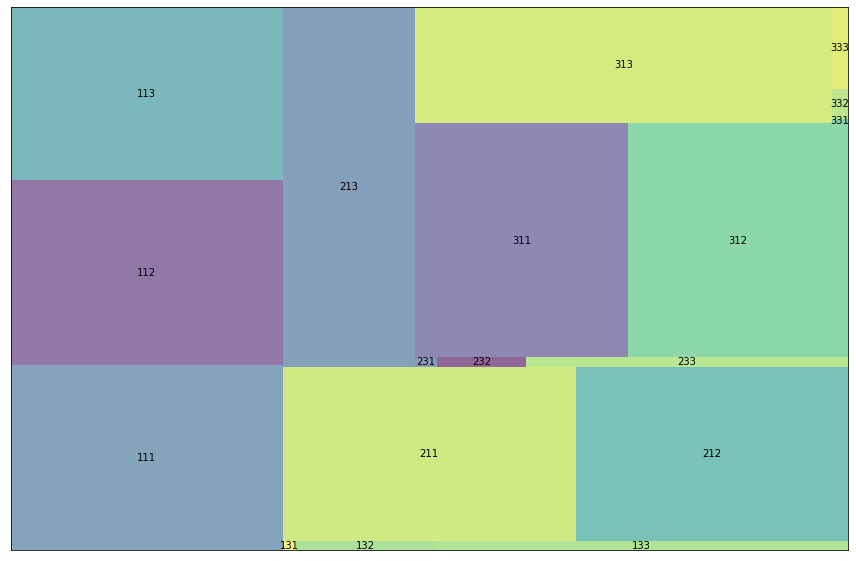

In [22]:
fig = plt.figure(figsize=(15, 10))
ax = squarify.plot(sizes=RFM_groups_size, label=RFM_groups_size.keys(), alpha=0.6 )
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

## 1.6 Conclusion  <a class="anchor" id="rfm_conclusion"></a> [⇪](#menu)

> #### Dans le cas présent, la méthode RFM ne semble pas adaptée.
> En effet, les scores de Fréquence sont difficile à découper en raison du trop grand nombre de clients qui ne font qu'un seul achat.<br>
> Il semble donc plus approprié de se diriger vers des méthodes de ségmentation non-supervisées telles que `KMeans`, `DBScan` ou le `Hierarchical Clustering`.

---
# 2. Feature Engineering <a class="anchor" id="fe"></a> [⇪](#menu)

>#### Nous avons vu avec la ségmentation RFM que si les variables `Recense` et `Montant` peuvent être utile au découpage des groupes, il n'en est pas de même pour la variable `Fréquence` que nous devons mettre de coté.

## 2.1 Regardons comment se répartissent nos clients avec ces deux seules variables...

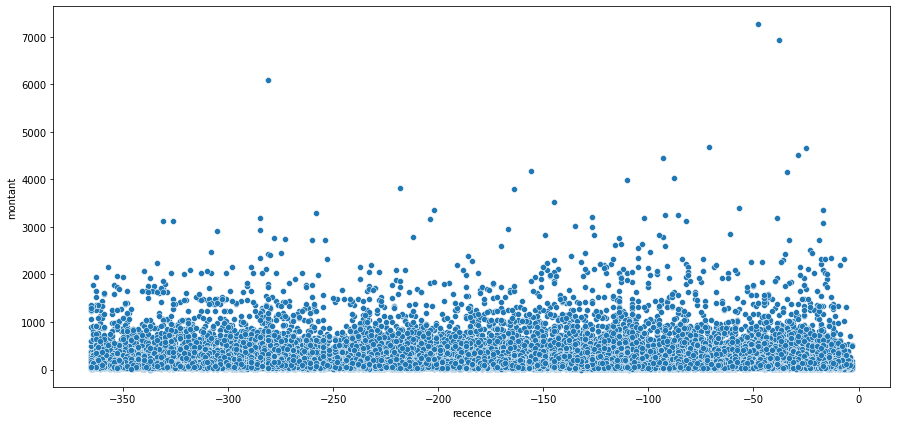

In [23]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(x=RFM_data['recence'], y=RFM_data['montant'])
plt.show()

>#### Il va être difficile de ségmenter correctement avec seulement ces 2 variables
> *(le plus probable est de voir apparaitre une ségmentation sur un seul axe)*.
> 
> Il va donc falloir compléter le jeu de données avec plus de variables issues de nos 9 jeux de données initiaux, ou encore créer de nouvelles variables utiles.

## 2.2 Ajoutons d'autres variables pour aider à créer des clusters

#### Préparons une table de référence qui nous permettra de faire les jointures sur toutes les tables utiles 

In [24]:
data_base_join = selection2[['order_id', 'customer_id', 'customer_unique_id']]
data_base_join.head(2)

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231


In [25]:
data_base_join.shape

(74213, 3)

#### Préparons notre nouveau jeu de données avec les colonnes `Recence` et `Montant` du RFM
> C'est à cette nouvelle table que l'on va ajouter petit à petit les variables que l'on va préparer ou récupèrer des autres datasets

In [26]:
data_clustering = data_base_join[['customer_unique_id']].merge(
        RFM_data[['customer_unique_id', 'recence', 'montant']],
        on='customer_unique_id', how='left'
    )
data_clustering.head(2)

,customer_unique_id,recence,montant
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82
1,af07308b275d755c9edb36a90c618231,-39,141.46


In [27]:
data_clustering.shape

(74213, 3)

### `olist_order_reviews_dataset.csv`
> ajoutons **les notes** données aux commandes par les clients et **le temps de réponse** à l'enquête de satisfaction *(que nous avions calculés lors de l'EDA)*.

#### Nous allons d'abord récupèrer ces variables `par commande`

In [28]:
data_fe1 = data_base_join.merge(
        data_reviews[['order_id', 'review_score', 'answer_days']].groupby('order_id').last(), 
        on='order_id', how='left'
    )
data_fe1.shape

(74213, 5)

In [29]:
data_fe1.head(2)

,order_id,customer_id,customer_unique_id,review_score,answer_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,0.0


#### Puis en faire la moyenne `par client`

In [30]:
data_fe2 = data_fe1.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,review_score,answer_days
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,4.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,0.0


In [31]:
data_fe2.shape

(72247, 3)

#### On vérifie que l'on a pas perdu ou ajouté de lignes dans les jointures...

In [32]:
selection2.customer_unique_id.nunique()

72247

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

In [33]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0


In [34]:
data_clustering.shape

(74213, 5)

### `olist_order_items_dataset.csv`
> ajoutons **le nombre moyen de produits** et le **le nombre total de produits** commandé par client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [35]:
data_fe = data_items.groupby('order_id').last()[['order_item_id']].reset_index()
data_fe.head(2)

,order_id,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1


In [36]:
data_fe = data_base_join.merge(data_fe, on='order_id', how='left')
data_fe.head(2)

,order_id,customer_id,customer_unique_id,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,1


In [37]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [38]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.rename(columns={'order_item_id': 'mean_items'}, inplace=True)
data_fe2.head(2)

,customer_unique_id,mean_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0


In [39]:
data_fe2.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_items,72247.0,1.141812,0.533297,1.0,1.0,1.0,1.0,20.0


In [40]:
data_fe3 = data_fe.groupby('customer_unique_id').sum().reset_index()
data_fe3.rename(columns={'order_item_id': 'total_items'}, inplace=True)
data_fe3.head(2)

,customer_unique_id,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [41]:
data_fe3.describe().T

,count,mean,std,min,25%,50%,75%,max
total_items,72247.0,1.175647,0.616571,1.0,1.0,1.0,1.0,24.0


In [42]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering = data_clustering.merge(data_fe3, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days,mean_items,total_items
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0,1.0,2
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0,1.0,1


In [43]:
data_clustering.shape

(74213, 7)

### `olist_orders_dataset.csv`
> ajoutons **le temps de livraison moyen** des commandes pour chaque client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [44]:
data_fe = data_base_join.merge(
        data_orders[['order_id', 'delivery_days']].groupby('order_id').last(), 
        on='order_id', how='left'
)
data_fe.head(2)

,order_id,customer_id,customer_unique_id,delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,14.0


In [45]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [46]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,delivery_days
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3.0


In [47]:
data_fe2.shape

(72247, 2)

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

In [48]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0,1.0,2,4.5
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0,1.0,1,14.0


In [49]:
data_clustering.shape

(74213, 8)

## 2.3 Préparons le jeu de données pour les algorithmes de clustering non-supervisés

### Supprimons la colonne `customer_unique_id` qui était utile pour faire les jointures, mais qui ne l'est pas pour le clustering

In [50]:
X_cluster = data_clustering[[*data_clustering.select_dtypes(include='number')]].copy()
X_cluster.head(2)

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-362,82.82,4.5,1.0,1.0,2,4.5
1,-39,141.46,4.0,0.0,1.0,1,14.0


In [51]:
X_cluster.shape

(74213, 7)

### Supprimons les `NaN`

In [52]:
X_cluster.isnull().mean()

recence          0.000000
montant          0.000000
review_score     0.006158
answer_days      0.006158
mean_items       0.000000
total_items      0.000000
delivery_days    0.000094
dtype: float64

In [53]:
X_cluster.dropna(inplace=True)

In [54]:
X_cluster.isnull().mean()

recence          0.0
montant          0.0
review_score     0.0
answer_days      0.0
mean_items       0.0
total_items      0.0
delivery_days    0.0
dtype: float64

In [55]:
X_cluster.shape

(73749, 7)

### Normalisons les variables
> En effet, dans la mesure où nous allons utiliser des algorithmes basés sur la distance et ou l'on constate clairement des différences d'échelles, il est préférable de normaliser nos données.

In [56]:
from sklearn.preprocessing import MinMaxScaler  # StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,

In [283]:
def fit_normalizer(data):
    """ Normalize the values of the provided dataset

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset used as reference for the scaler

    Returns
    -------
    MinMaxScaler
        the scaler instance
    """

    scaler = MinMaxScaler()
    scaler.fit(data)

    return scaler


def normalize(data, scaler):
    """ Transform the provided dataset using the provided scaler.

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """

    dt = data.copy()
    dt = pd.DataFrame(scaler.transform(dt), index=dt.index, columns=dt.columns)

    return dt


def get_inverse_normalization(scaler, data):
    """ Transform the provided dataset using the provided scaler back to the original scales

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset
    columns: list
        the list of columns to consider

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """
    
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)

In [58]:
model_scaler = fit_normalizer(X_cluster)
X_cluster_norm = normalize(X_cluster, model_scaler)

In [59]:
X_cluster_norm.head(2)

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,0.008287,0.011384,0.875,0.002874,0.0,0.043478,0.016908
1,0.900552,0.019445,0.750,0.000000,0.0,0.000000,0.062802


In [60]:
X_cluster_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,73749.0,0.517587,0.274940,0.0,0.276243,0.516575,0.748619,1.0
montant,73749.0,0.023218,0.030424,0.0,0.008797,0.015226,0.025741,1.0
review_score,73749.0,0.783458,0.324570,0.0,0.750000,1.000000,1.000000,1.0
answer_days,73749.0,0.006849,0.020019,0.0,0.000000,0.002874,0.008621,1.0
mean_items,73749.0,0.007565,0.028139,0.0,0.000000,0.000000,0.000000,1.0
total_items,73749.0,0.009571,0.032214,0.0,0.000000,0.000000,0.000000,1.0
delivery_days,73749.0,0.055675,0.045526,0.0,0.024155,0.043478,0.072464,1.0


### Créeons un jeu de données réduit pour que les algorithmes puissent travailler plus rapidement dans un premier temps

In [61]:
X_sample = X_cluster_norm.sample(frac=0.25, random_state=random_seed).reset_index(drop=True).copy()

---
# 3. Apprentissage non-supervisé *(sans optimisation*)  <a class="anchor" id="unsupervised"></a> [⇪](#menu)

- 🚩 ICI on parle de l'apprentisage suppervisé 
- 🚩 ICI on explique que l'on a pas besoin de train/validation/test split
> La plupart des algorithmes de clustering ne peuvent pas "prédire" pour de nouvelles données. K-means est une rare exception, car vous pouvez effectuer une classification par plus proche voisin sur les centroïdes pour prédire. Mais pour toute méthode qui n'utilise pas les centroïdes, on ne voit pas très bien comment on pourrait appliquer cela à des données "test".
- 🚩 ICI on parle de la metric utilisé dans le cadre du clustering --> silhouette (ses avantages, ses défauts, ses bornes -1/+1 etc.)

### Définissons la métrique utilisée par la fonction de recherche des hyper-paramètres

In [62]:
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples

In [63]:
def cv_silhouette_scorer(estimator, X_ref):
    estimator.fit(X_ref)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X_ref.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X_ref, cluster_labels)

### Définissons des fonctions pour afficher et enregistrer les scores

In [64]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance

In [65]:
scores_df = pd.DataFrame(columns=['Method', 'params', 'best_params', 'silhouette', 'Training time', 'Inference time'])
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)


def get_clustering_scores(method_name, model, X_ref=None, param_grid=None, best_params=None, training_time=None, inference_time=None, register=False, **others):
    """ Compute / Display / Save scores for the provided model

    More precisely, it compute the scores then call various function to display and save them.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    """

    if X_ref is None:
        X_ref = X_cluster

    scores = {
        'silhouette': cv_silhouette_scorer(model, X_ref),
    }

    # Register score and replace if it already exists
    if register:
        save_score(method_name, param_grid, best_params, training_time, inference_time, **scores)

    # Basic report
    scores_str = ""
    for key in scores.keys():
        scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"

    print(f"--- {method_name} ---".ljust(100, '-'), "\n\n", scores_str, sep="")

    # Silhouette plot
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    visualizer.fit(X_ref)
    visualizer.show();

In [66]:
def save_score(method_name, param_grid, best_params, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """

    idx = np.where(scores_df.Method == method_name)[0]
    idx = idx[0] if idx.size > 0 else len(scores_df.index)

    silhouette = scores.get('silhouette', None)

    scores_df.loc[idx] = [method_name, param_grid, best_params, silhouette, training_time, inference_time]
    scores_df.to_csv(scores_path, index=False)

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Comme on a des algorithmes qui utilisent les distances, il est préférable de **normaliser les données** !

---
# 3. K-Means <a class="anchor" id="kmeans"></a> [⇪](#menu)

Le K-means clustering *(ou segmentation par K-moyennes)* est une technique qui vise à partitionner *n* observations en *k* clusters dans lesquels chaque observation appartient au cluster dont la moyenne est la plus proche. 

In [93]:
from sklearn.cluster import KMeans

## 3.1 Basic Kmeans
#### Commençons par regarder comment se comporte le K-means avec les données que nous avons déjà
*(hors Fréquence puisque l'on a vu que c'est une donnée peu pertinente avec seulement 3% des clients qui achètent plus d'une fois)*

In [114]:
X_basic = X_sample[['recence', 'montant']]
kmeans = KMeans(random_state=random_seed).fit(X_basic)

--- Kmeans [basic] ---------------------------------------------------------------------------------

          SILHOUETTE : 0.5080



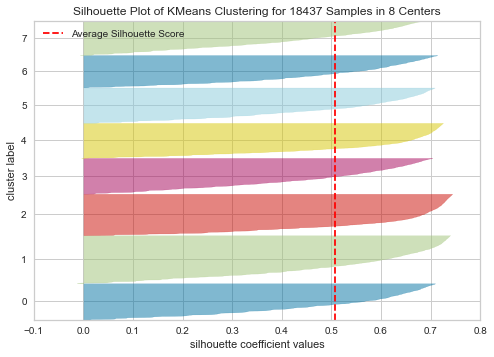

In [115]:
get_clustering_scores("Kmeans [basic]",  model=kmeans, X_ref=X_basic, register=True)

>#### Les silhouettes sont bien marquées, mais est-ce que ces groupes nous intéressent ??

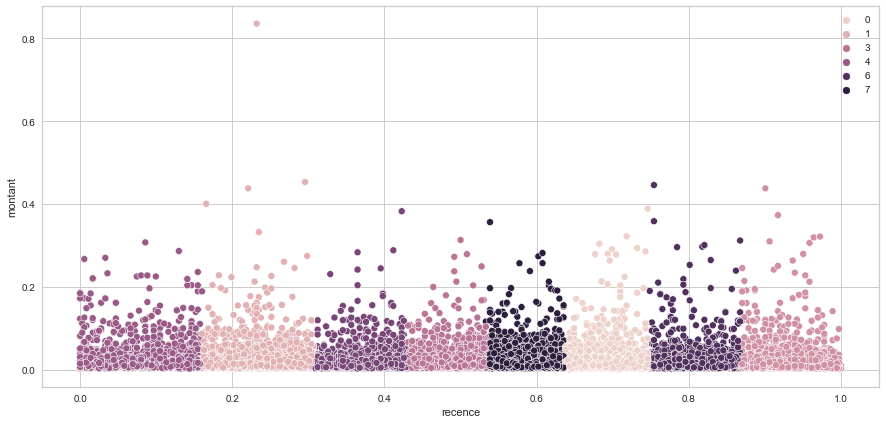

In [117]:
fig = plt.figure(figsize=(15,7))
sns.scatterplot(x=X_basic['recence'], y=X_basic['montant'], hue=kmeans.labels_)
plt.show()

> Ce découpage ne présente aucun intérêt pour notre recherche de groupes types de clients.<br>
> Nous allons donc utiliser les variables supplémentaires que nous avons préparé un peu plus tôt.

## 3.2 KMeans + Feature Engineering
#### Ajoutons les variables que nous avons préparé dans la section Feature Engineering

In [118]:
X_fe = X_sample
kmeans = KMeans(random_state=random_seed).fit(X_fe)

--- Kmeans [fe] ------------------------------------------------------------------------------------

          SILHOUETTE : 0.4285



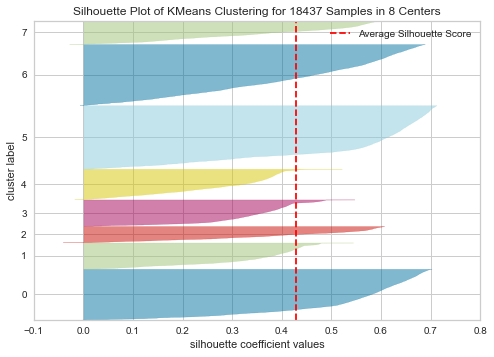

In [119]:
get_clustering_scores("Kmeans [fe]",  model=kmeans, X_ref=X_fe, register=True)

>#### On note que notre silhouette_score est à la baisse, mais on voit aussi clairement que le nombre de cluster choisi n'est pas du tout adapté...
> Nous allons donc essayer de trouver le nombre de cluster idéal

## 3.3 KMeans + Elbow method
La Elbow method *(ou méthode du coude)* consiste à tester KMeans avec différentes valeurs de k pour sélectionner le nombre optimal de clusters. Comme on doit spécifier à l'avance le nombre de k à choisir, l'algorithme est quelque peu naïf - il affecte tous les membres à k clusters même si ce n'est pas le bon k pour l'ensemble de données. Idéalement, on choisit le point qui à la plus grande valeur *(selon la métrique choisie)* pour déterminer où se trouve le coude et donc choisir la valeur de **k**.

In [120]:
from yellowbrick.cluster import KElbowVisualizer

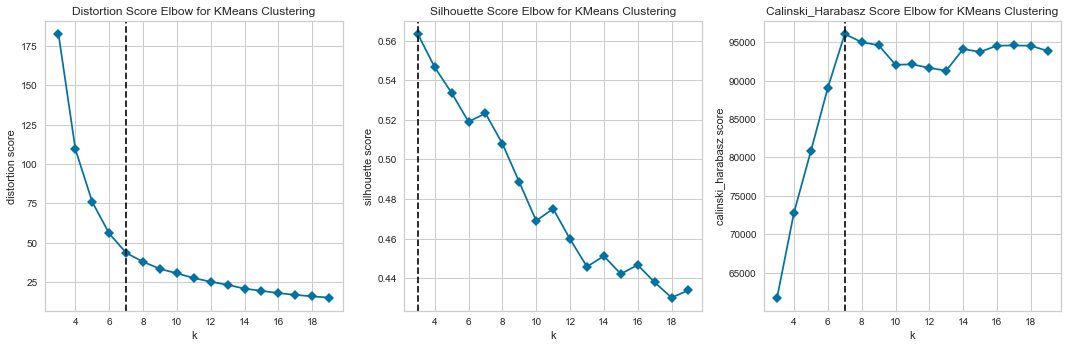

In [175]:
methods = ['distortion', 'silhouette', 'calinski_harabasz']
kmeans = KMeans(random_state=random_seed)

fig = plt.figure(figsize=(15, 5))
for i, m in enumerate(methods):
    ax = plt.subplot(1, 3, i+1)
    visualizer = KElbowVisualizer(kmeans, k=(3, 20), metric=m, timings=False)
    visualizer.fit(X_basic)
    plt.title(f"{m.title()} Score Elbow for KMeans Clustering")
    ax.set_ylabel(f'{m} score')
    ax.set_xlabel('k')
    #visualizer.show();

plt.tight_layout()
plt.show()

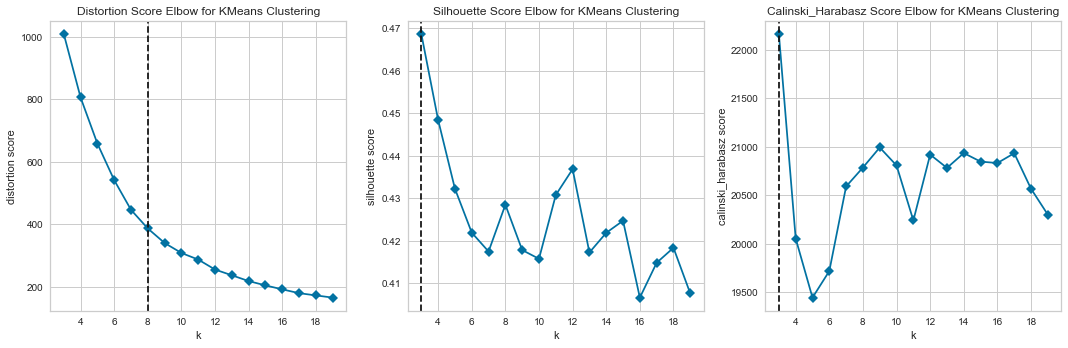

In [174]:
methods = ['distortion', 'silhouette', 'calinski_harabasz']
kmeans = KMeans(random_state=random_seed)

fig = plt.figure(figsize=(15, 5))
for i, m in enumerate(methods):
    ax = plt.subplot(1, 3, i+1)
    visualizer = KElbowVisualizer(kmeans, k=(3, 20), metric=m, timings=False)
    visualizer.fit(X_sample)
    plt.title(f"{m.title()} Score Elbow for KMeans Clustering")
    ax.set_ylabel(f'{m} score')
    ax.set_xlabel('k')
    #visualizer.show();

plt.tight_layout()
plt.show()

>#### Conclusion **????**

## 3.4 KMeans + Silhouettes
Affichons les courbes silhouettes pour diverses valeurs **k** pour mieux visualiser le clustering

In [311]:
def plot_silhouette(model, data):

    model = model.fit(data)
    score = silhouette_score(data, model.labels_)
    print(f"Silhouette score moyen: {score:.3f}")

    plt.figure(figsize=(10, 7))
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    visualizer.fit(data)
    visualizer.show();

    return model

In [312]:
def get_means(fitted_model, X_cluster):
    X_labels = pd.DataFrame(fitted_model.labels_, columns=['label'])
    X_results = X_cluster.merge(X_labels, left_index=True, right_index=True)

    groups = {}
    for i in range(fitted_model.n_clusters):
        groups[i] = X_results[X_results.label == i].mean()

    return pd.DataFrame.from_dict(groups).T.drop(columns=['label'])

#### Silhouette avec **3 clusters**

Silhouette score moyen: 0.469


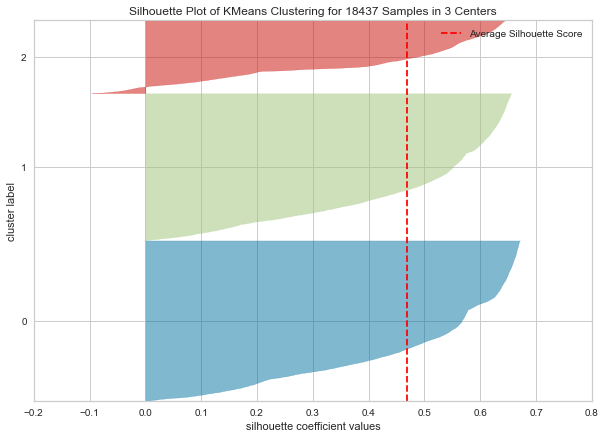

In [313]:
fitted_model = plot_silhouette(KMeans(n_clusters=3, random_state=random_seed), X_sample)

In [314]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample))

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-89.697184,161.546275,4.693584,2.228194,1.114976,1.158416,9.550459
1,-268.041480,166.893774,4.685697,2.623264,1.106744,1.222113,12.639222
2,-189.364642,191.288368,1.777857,2.228859,1.287410,1.367196,19.431423


>#### On constate que:
> - les valeurs de silhouettes pour les 3 clusters sont assez hautes sur les premiers points, mais déclinent très vite; ce qui laisse supposer qu'il pourrait y avoir plus de clusters.
> - les clusters 0 et 1 regroupent beaucoup de points et peuvent éventuellement être découpés.
> - le cluster 2 présente plusieurs points avec ess valeurs de silhouette négatives, ce qui laisse penser qu'ils ont été assignés au mauvais cluster.

> Même si ce découpage semble intéressant, plusieurs indicateurs nous laissent penser que ce n'est pas le découpage idéal.

#### Silhouette avec **4 clusters**

Silhouette score moyen: 0.448


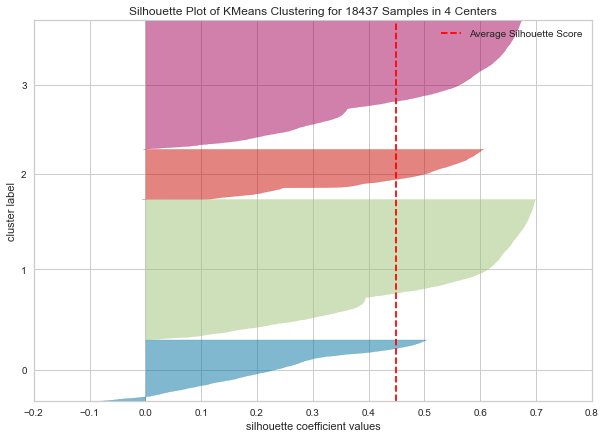

In [315]:
fitted_model = plot_silhouette(KMeans(n_clusters=4, random_state=random_seed), X_sample)

In [316]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample))

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-184.041064,165.932427,3.454224,2.579558,1.150006,1.265904,14.117564
1,-85.851754,162.662400,4.834214,2.203655,1.111649,1.150594,9.264543
2,-185.695545,197.484439,1.229717,2.255294,1.332371,1.382838,20.721191
3,-272.245946,167.200692,4.820271,2.529873,1.105430,1.219457,12.466360


>#### On constate que:
> - les valeurs de silhouettes pour les 3 clusters sont assez hautes sur les premiers points, mais déclinent très vite; ce qui laisse supposer qu'il pourrait y avoir plus de clusters.
> - les clusters 0 et 1 regroupent beaucoup de points et peuvent éventuellement être découpés.
> - le cluster 2 présente plusieurs points avec ess valeurs de silhouette négatives, ce qui laisse penser qu'ils ont été assignés au mauvais cluster.

> Même si ce découpage semble intéressant, plusieurs indicateurs nous laissent penser que ce n'est pas le découpage idéal.

#### Silhouette avec **5 clusters**

Silhouette score moyen: 0.432


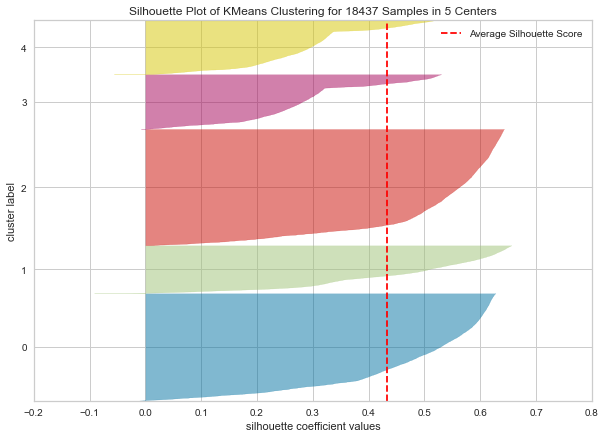

In [317]:
fitted_model = plot_silhouette(KMeans(n_clusters=5, random_state=random_seed), X_sample)

In [318]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample))

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-265.130035,168.237779,4.991504,2.546007,1.104569,1.226697,12.272131
1,-186.468131,198.700401,1.196454,2.221504,1.334554,1.385013,21.133721
2,-89.636960,160.483599,4.997283,2.225579,1.106780,1.148653,9.138909
3,-267.223312,165.012045,3.629171,2.680083,1.134289,1.253112,14.629549
4,-95.146969,168.691132,3.674149,2.226976,1.148887,1.201458,11.328249


#### Silhouette avec **6 clusters**

Silhouette score moyen: 0.422


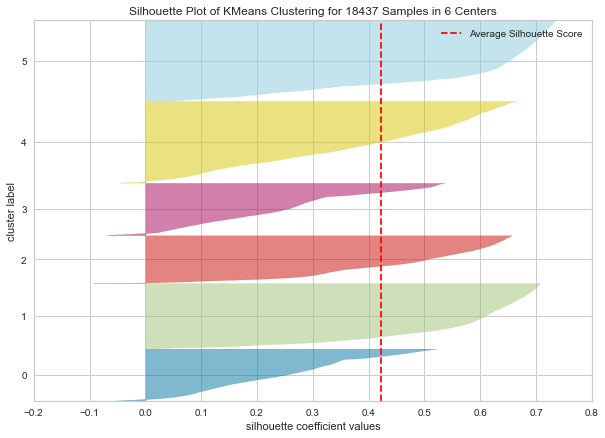

In [319]:
fitted_model = plot_silhouette(KMeans(n_clusters=6, random_state=random_seed), X_sample)

In [320]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample))

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-92.366047,169.173538,3.660401,2.224970,1.151167,1.203008,11.188728
1,-300.357547,173.825031,4.990472,2.580622,1.107827,1.251258,12.012335
2,-186.354671,198.538326,1.192979,2.219651,1.334703,1.384948,21.153979
3,-271.045669,165.341402,3.608556,2.718465,1.132480,1.251575,14.634659
4,-181.716046,160.245722,4.943503,2.447477,1.108610,1.187123,11.903102
5,-63.373398,160.176748,4.998847,2.128652,1.102939,1.134803,8.473561


#### Silhouette avec **7 clusters**

Silhouette score moyen: 0.417


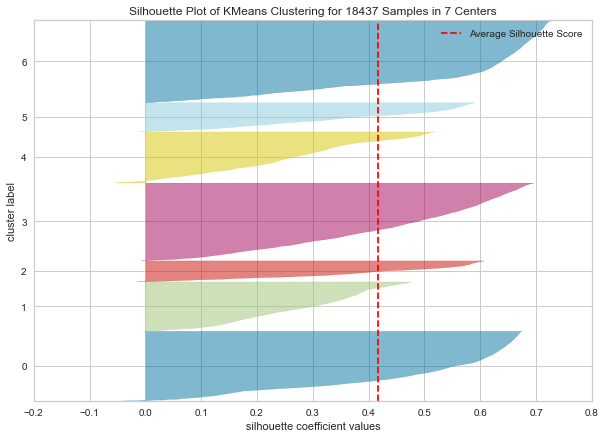

In [321]:
fitted_model = plot_silhouette(KMeans(n_clusters=7, random_state=random_seed), X_sample)

In [322]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample))

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-305.344624,175.148118,4.908336,2.586179,1.108510,1.251546,12.005044
1,-91.638796,167.185903,3.726101,2.251881,1.148411,1.201087,10.922833
2,-100.259113,197.963852,1.241872,2.296223,1.347783,1.370443,15.914614
3,-183.715912,160.343024,4.993610,2.458212,1.106522,1.184008,11.777001
4,-251.006863,164.192769,3.609797,2.627251,1.133697,1.247477,15.162683
5,-246.971691,197.351430,1.224581,2.226940,1.320712,1.394197,24.163010
6,-64.370464,159.967503,4.998614,2.133695,1.102235,1.134829,8.498950


#### Silhouette avec **8 clusters**

Silhouette score moyen: 0.428


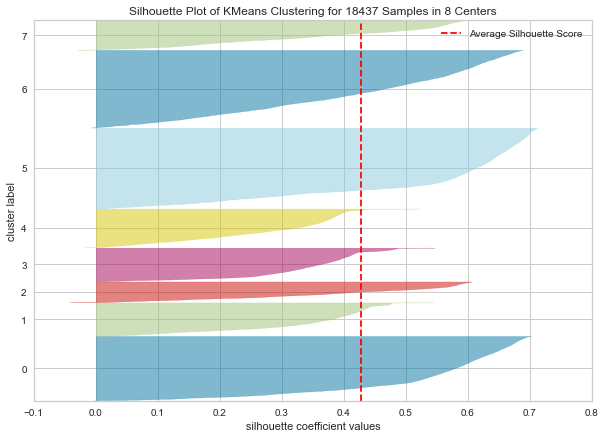

In [323]:
fitted_model = plot_silhouette(KMeans(n_clusters=8, random_state=random_seed), X_sample)

In [324]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample))

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
0,-300.923175,173.908251,4.990222,2.586628,1.108537,1.253016,12.012611
1,-65.261567,171.421937,3.734629,2.205017,1.148365,1.186305,10.047090
2,-99.739604,198.182436,1.243069,2.279868,1.348515,1.371287,15.860231
3,-299.036020,173.721508,3.680138,2.410602,1.133394,1.258852,14.150000
4,-181.446325,156.757192,3.647999,2.681914,1.135907,1.230566,14.594033
5,-63.751464,160.088090,4.998727,2.125923,1.102283,1.134199,8.481623
6,-182.501719,160.403145,4.993697,2.470158,1.106938,1.184343,11.748171
7,-246.567301,196.910113,1.224924,2.233733,1.319121,1.389711,24.169603


#### Silhouette avec **9 clusters**

Silhouette score moyen: 0.418


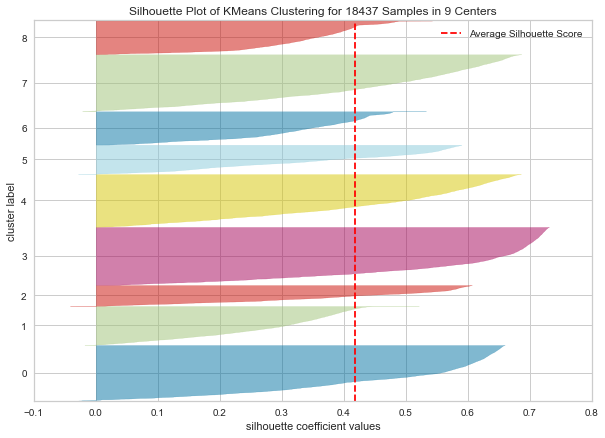

In [325]:
fitted_model = plot_silhouette(KMeans(n_clusters=9, random_state=random_seed), X_sample)

In [333]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['montant'])

,recence,montant,review_score,answer_days,mean_items,total_items,delivery_days
3,-46.202693,155.559125,4.999291,2.115107,1.101169,1.125089,7.754193
1,-181.446325,156.757192,3.647999,2.681914,1.135907,1.230566,14.594033
4,-217.168097,158.091287,4.993630,2.542252,1.095359,1.178237,12.776261
7,-132.176790,165.445871,4.994939,2.330682,1.113762,1.173897,10.464208
6,-65.233951,171.285111,3.734259,2.204938,1.148457,1.185185,10.048148
8,-299.036020,173.721508,3.680138,2.410602,1.133394,1.258852,14.150000
0,-308.683044,177.834171,4.989669,2.550626,1.112015,1.270410,11.817716
5,-246.567301,196.910113,1.224924,2.233733,1.319121,1.389711,24.169603
2,-99.739604,198.182436,1.243069,2.279868,1.348515,1.371287,15.860231


In [329]:
data_clustering.montant.describe()

count    74213.000000
mean       169.126755
std        222.862315
min          0.000000
25%         64.000000
50%        110.890000
75%        187.430000
max       7274.880000
Name: montant, dtype: float64

In [ ]:
stop

In [94]:
import math

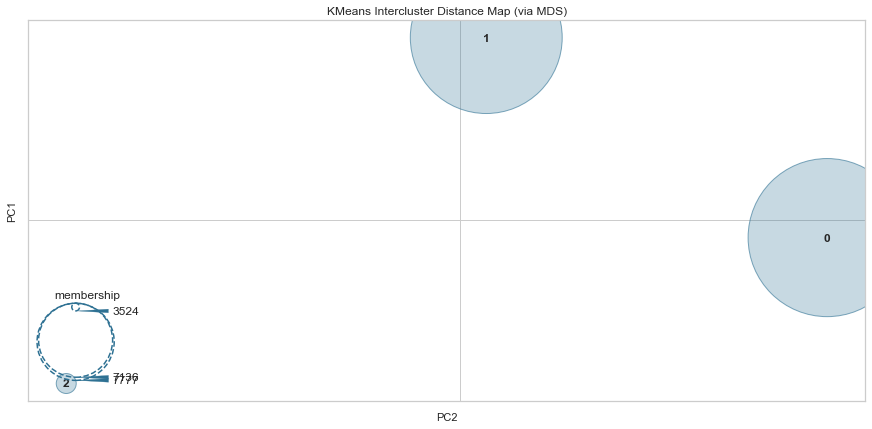

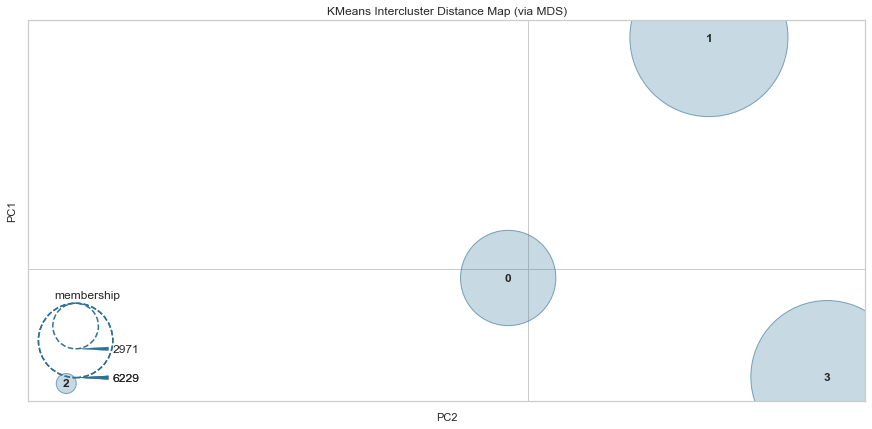

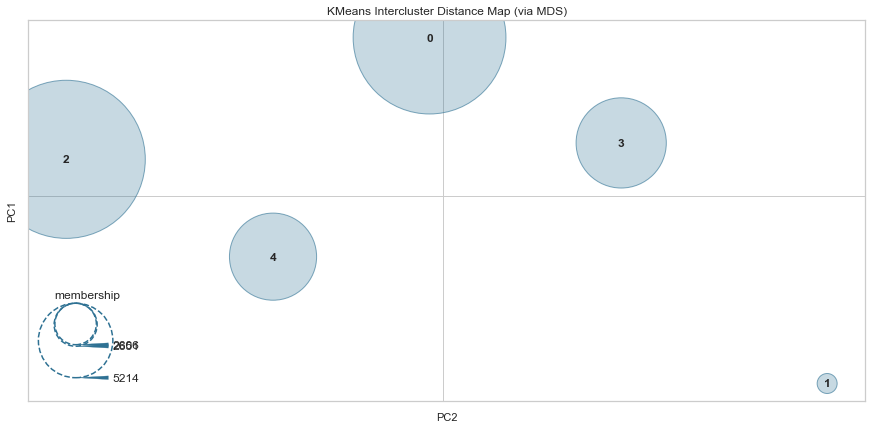

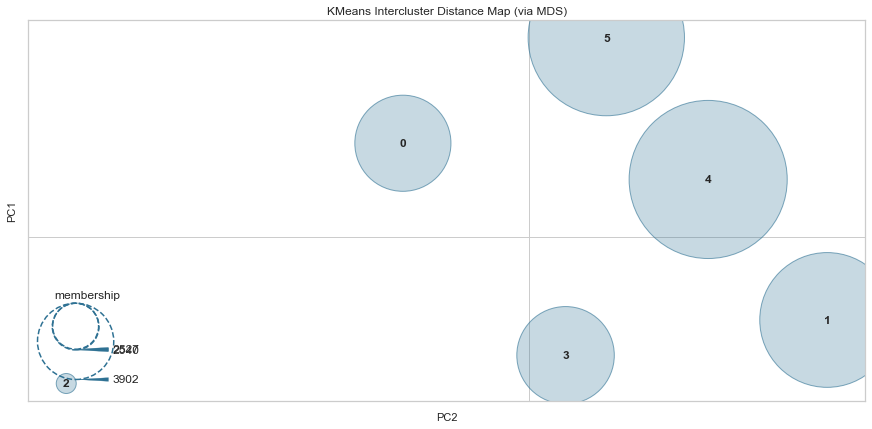

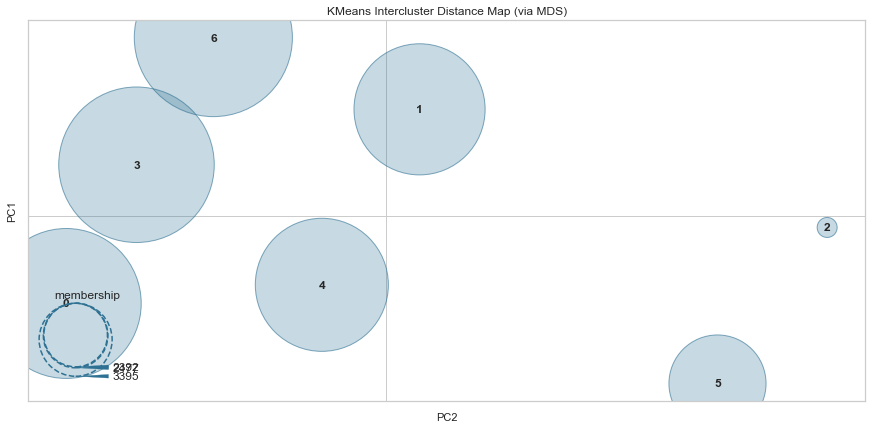

In [100]:
for j in range(3, 8):
    fig = plt.figure(figsize=(15, 7))
    plt.title(f"KMeans with {j} clusters")
    model = KMeans(n_clusters=j, random_state=0)
    visualizer = InterclusterDistance(model, colors='yellowbrick')
    visualizer.fit(X_sample)
    visualizer.show();

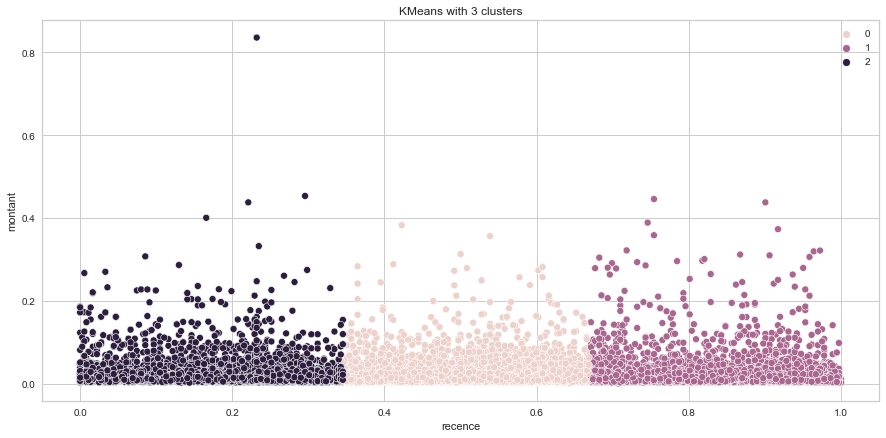

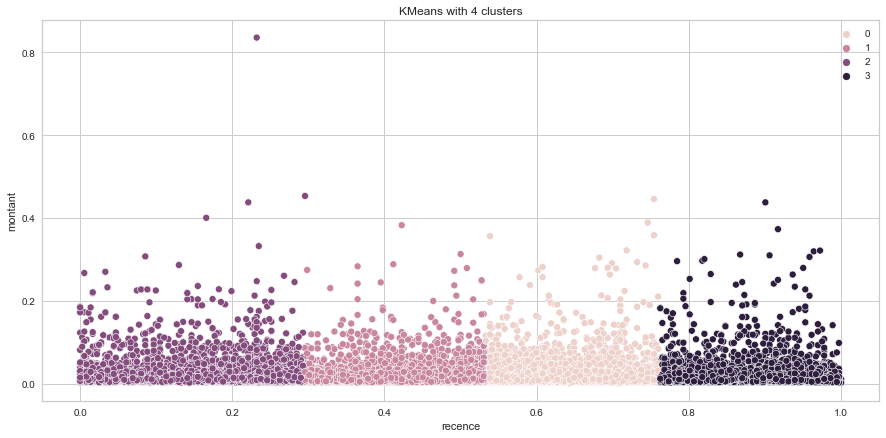

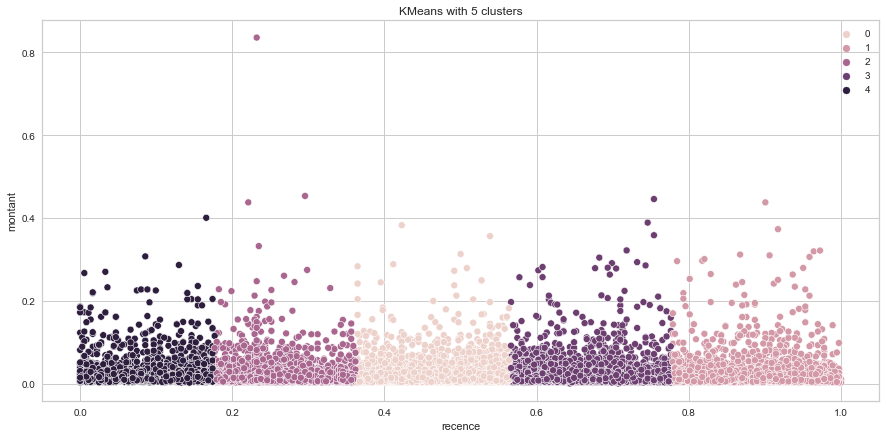

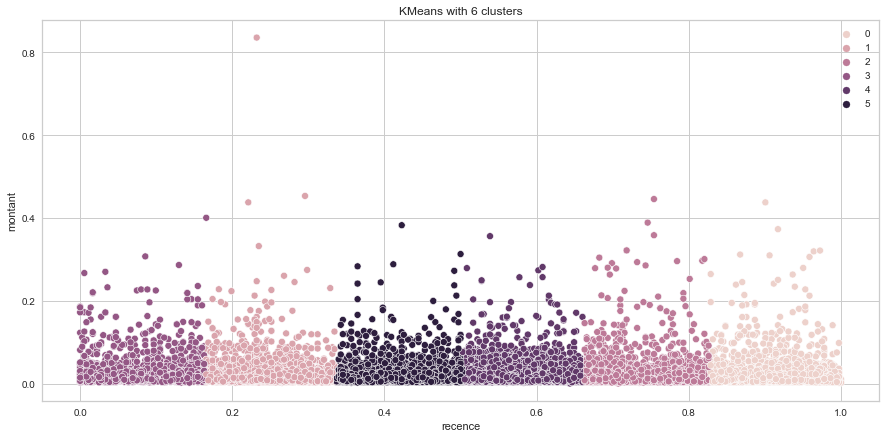

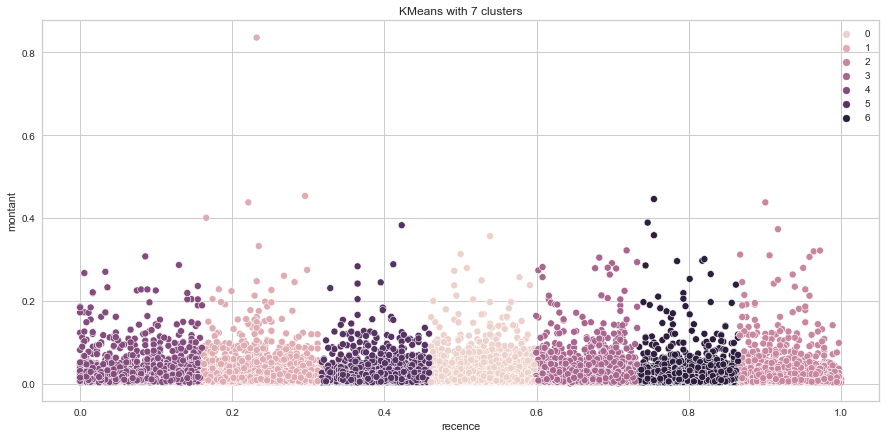

In [103]:
k_range = range(3, 8)
X_xxx = X_sample[['recence', 'montant']]
k_size = len(k_range)
for i, j in enumerate(k_range):
    model = KMeans(n_clusters=j, random_state=0)
    model.fit(X_xxx)

    fig = plt.figure(figsize=(15, 7))
    plt.title(f"KMeans with {j} clusters")
    sns.scatterplot(x=X_xxx['recence'], y=X_xxx['montant'], hue=model.labels_)
    plt.show()